In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import math
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse
from scipy.sparse import csr_matrix
from sklearn.utils.sparsefuncs import inplace_row_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
sc.settings.set_figure_params(dpi=80, facecolor='white')

Global seed set to 0


# Get Raw Data

In [2]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [ ]:
del scran_adata.uns
del scran_adata.obsm
del scran_adata.varm
del scran_adata.obsp
del scran_adata.raw

In [ ]:
def log1pnormalized2counts(adata, scale_by='sizeFactor'):
    adata.X.data = np.exp(adata.X.data) - 1  # undo log1
    inplace_row_scale(adata.X, adata.obs[scale_by].values)  # tocounts
    adata.X.data = adata.X.data.astype(int)

In [ ]:
log1pnormalized2counts(scran_adata, scale_by='sizeFactor')

In [ ]:
scran_adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_raw.h5ad")

# Normalization

In [2]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_raw.h5ad")

In [7]:
adata.layers['counts'] = adata.X.copy()

In [8]:
sc.pp.normalize_total(adata)

In [9]:
sc.pp.log1p(adata)

In [10]:
adata.layers['log1pPF'] = adata.X.copy()

In [11]:
sc.pp.normalize_total(adata)
adata.layers['PFlog1pPF'] = adata.X.copy()

In [12]:
adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.h5ad")

## Create gene-subset objects

In [3]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.h5ad")

Filter to only protein coding genes

In [4]:
pcgs = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/fca/protein_coding_genes.tsv", sep="\t")

In [5]:
adata_pcgs = adata[:, list(set(pcgs['gene']).intersection(set(adata.var_names)))]

In [6]:
adata_pcgs.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.pcgs.h5ad")

Filter to FCA's highly variable genes

In [7]:
hvgs = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/fca/fca_subsampled_hvg.tsv", sep="\t")

In [8]:
adata_fca_hvgs = adata[:, list(set(hvgs['gene']).intersection(set(adata.var_names)))]

In [9]:
adata_fca_hvgs.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.fca_hvgs.h5ad")

# Annotation

### Load and transfer annotations

In [2]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.h5ad")

In [3]:
cellid_labels = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/fca/cellid_labels.tsv", sep="\t").set_index('cell')

In [4]:
cellid_labels['value'] = pd.Categorical(cellid_labels['value'])
cellid_labels['value'] = cellid_labels['value'].cat.remove_categories(['unassigned'])

In [5]:
cellid_labels['value']

cell
AAACCCACACGGCGTT-1      Vascular endothelial cells
AAACCCACAGAAGTGC-1                   Retinal cells
AAACGAAAGGTATTGA-1                     CNS neurons
AAACGAAAGTAGATCA-1                             NaN
AAACGAACACCCTCTA-1                   Retinal cells
                                   ...            
TTTGGTTTCGAAGCCC-118                           NaN
TTTGGTTTCGAGATAA-118                           NaN
TTTGTTGAGGATATAC-118                  Acinar cells
TTTGTTGGTTTGGAGG-118                  Acinar cells
TTTGTTGTCCTCTCGA-118                 Retinal cells
Name: value, Length: 909536, dtype: category
Categories (33, object): ['Acinar cells', 'Adrenocortical cells', 'Bronchiolar and alveolar epithelial cells', 'CNS glia', ..., 'Stellate cells', 'Stromal cells', 'Ureteric bud cells', 'Vascular endothelial cells']

In [6]:
adata.obs['cellid_label'] = cellid_labels['value']

In [7]:
celltypes = adata.obs['cellid_label'].cat.categories
celltypes

Index(['Acinar cells', 'Adrenocortical cells',
       'Bronchiolar and alveolar epithelial cells', 'CNS glia', 'CNS neurons',
       'Cardiomyocytes', 'Ciliated epithelial cells', 'Ductal cells',
       'Endocardial cells', 'Epicardial fat cells', 'Erythroblasts',
       'Goblet cells', 'Hepatoblasts', 'Intestinal epithelial cells',
       'Lymphatic endothelial cells', 'Lymphoid cells', 'Megakaryocytes',
       'Mesangial cells', 'Mesothelial cells', 'Metanephric cells',
       'Neuroendocrine cells', 'PNS glia', 'PNS neurons',
       'Parietal and chief cells', 'Retinal cells', 'STC2_TLX1 positive cells',
       'Skeletal muscle cells', 'Smooth muscle cells',
       'Squamous epithelial cells', 'Stellate cells', 'Stromal cells',
       'Ureteric bud cells', 'Vascular endothelial cells'],
      dtype='object')

### Visualize annotations

In [30]:
annotated_obj = sc.read_h5ad("/project2/gilad/katie/ebQTL/highpass_combinedFiles/102andPilot_MetaAdded_QCadded_filtered_noNorm_5000VarFeatNoBatchKey_LinearSCVI022222.h5ad")

In [32]:
pd.DataFrame(annotated_obj.obsm['X_umap'], index=annotated_obj.obs_names).to_csv("/project2/gilad/jpopp/ebQTL/temp/umap.txt")

In [33]:
umap = pd.read_csv("/project2/gilad/jpopp/ebQTL/temp/umap.txt")
umap.set_index("cell", inplace=True)
umap = umap.reindex(adata.obs_names)
umap

0          1
cell                                      
AAACCCACACGGCGTT-1    15.515979   5.845357
AAACCCACAGAAGTGC-1    -2.536000   5.044168
AAACGAAAGGTATTGA-1    -2.441272  14.546612
AAACGAAAGTAGATCA-1     8.380158  -0.924759
AAACGAACACCCTCTA-1    -2.431579   3.385401
...                         ...        ...
TTTGGTTTCGAAGCCC-118   8.446073  -2.793889
TTTGGTTTCGAGATAA-118   6.610786  -3.713170
TTTGTTGAGGATATAC-118   0.673176   2.839856
TTTGTTGGTTTGGAGG-118   3.356653   5.634020
TTTGTTGTCCTCTCGA-118  -2.747501   3.488048

[909536 rows x 2 columns]

In [34]:
adata.obsm['X_umap'] = np.array(umap)

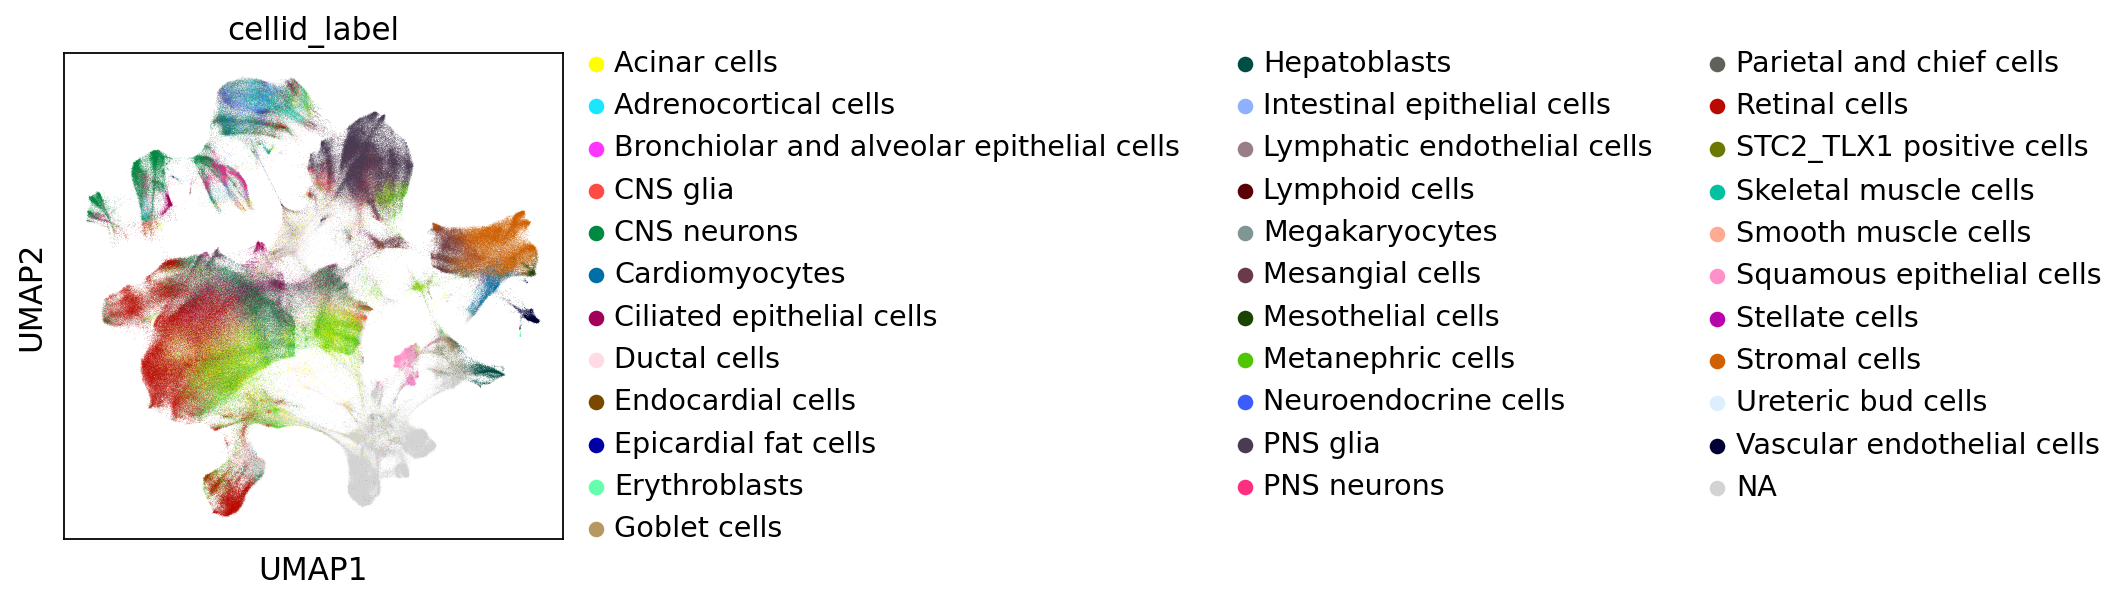

In [35]:
sc.pl.umap(adata, color='cellid_label')

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


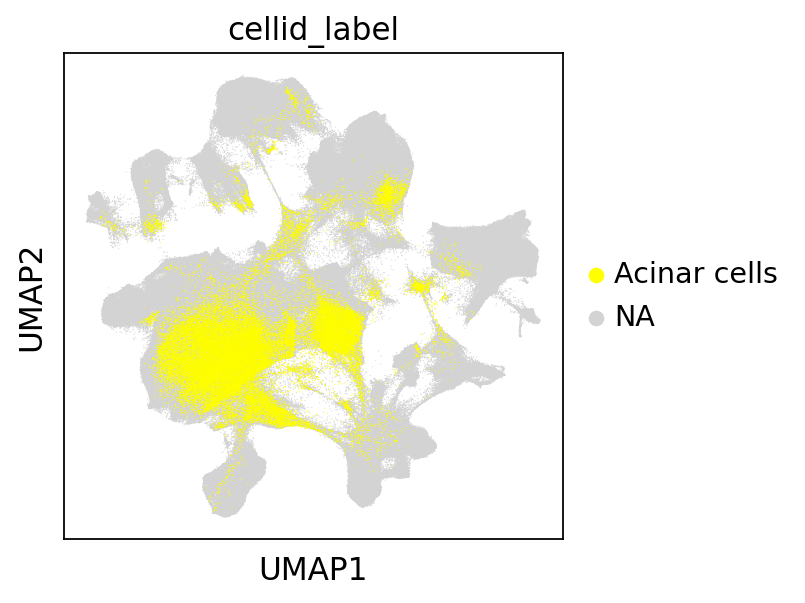

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


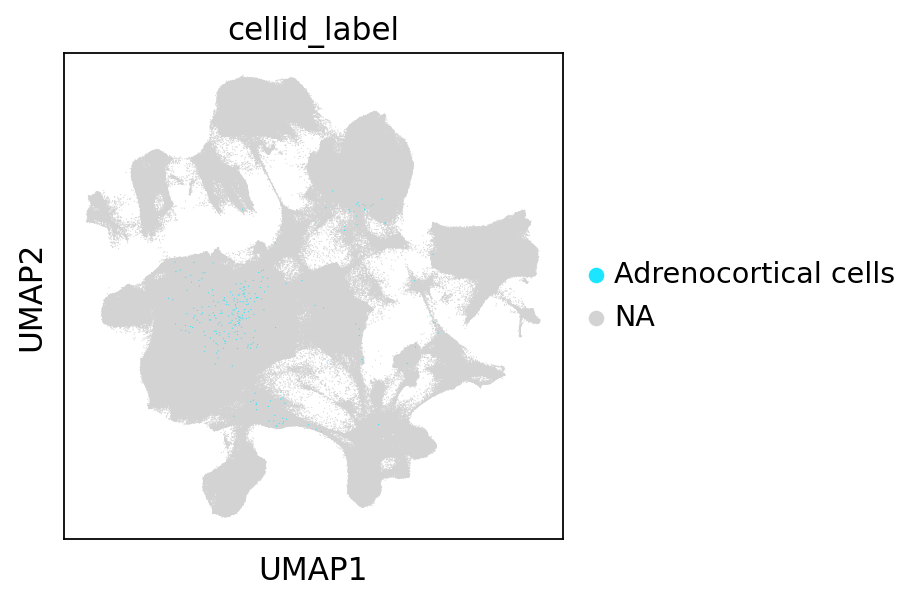

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


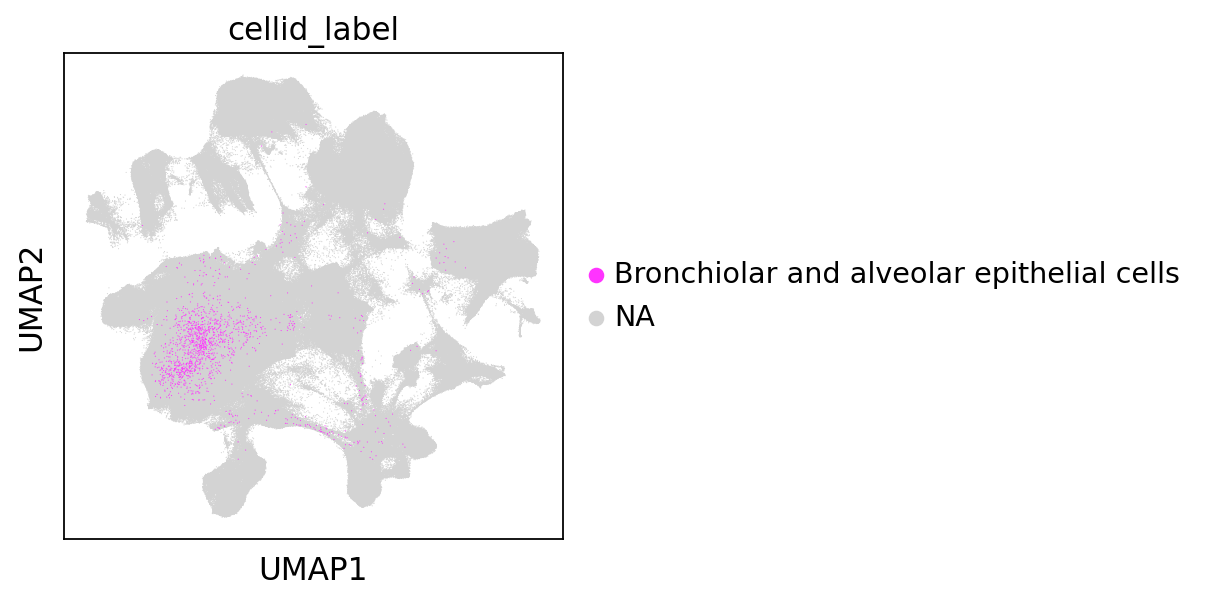

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


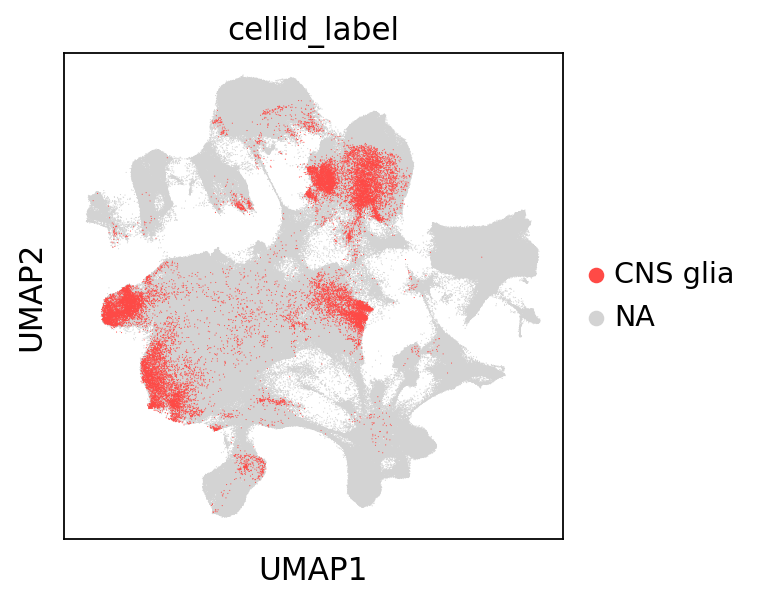

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


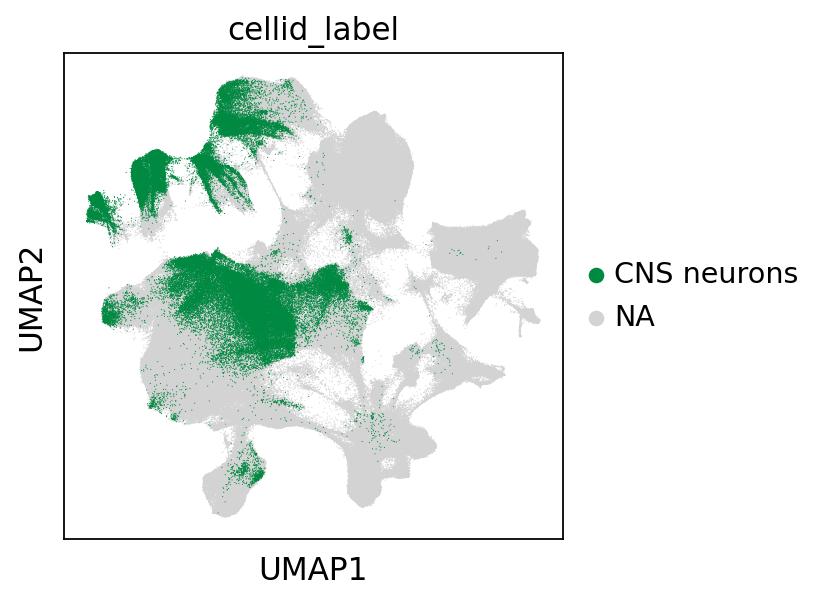

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


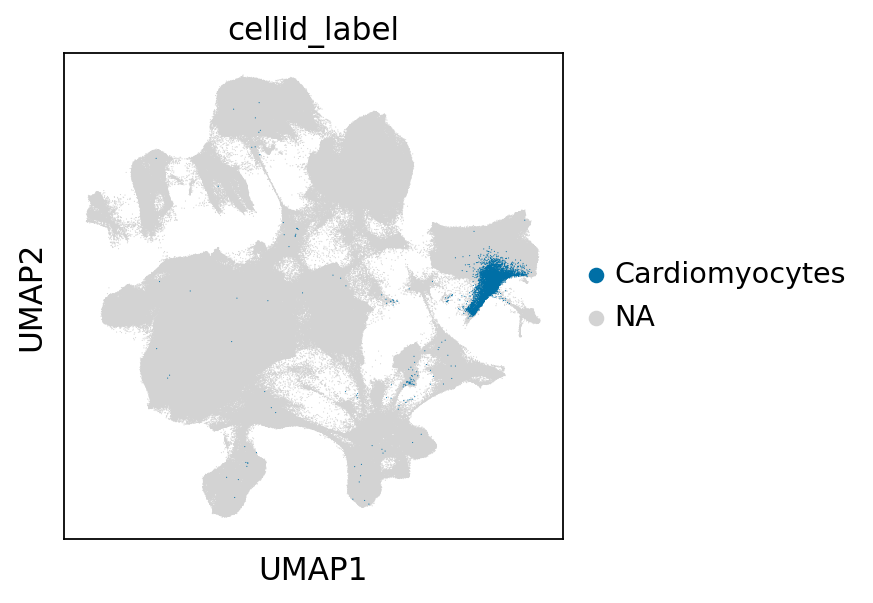

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


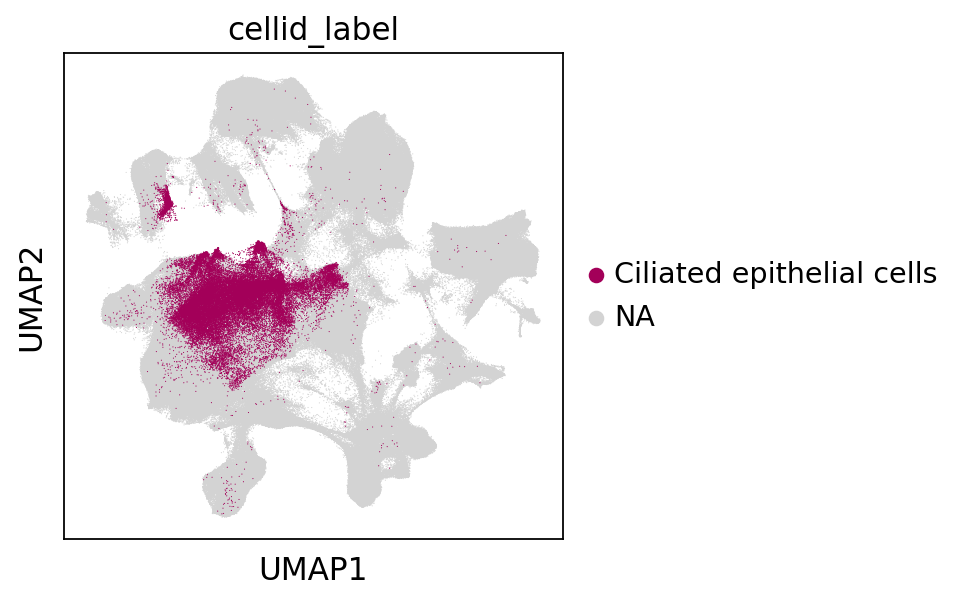

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


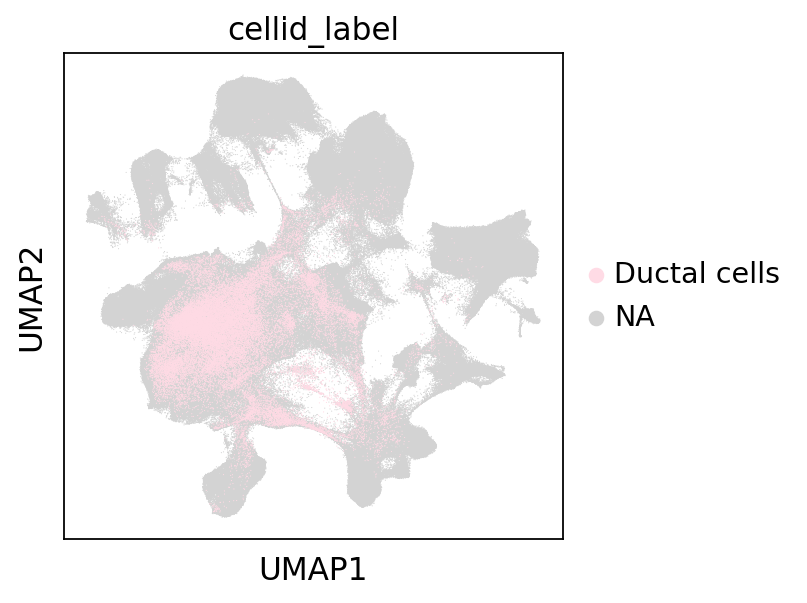

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


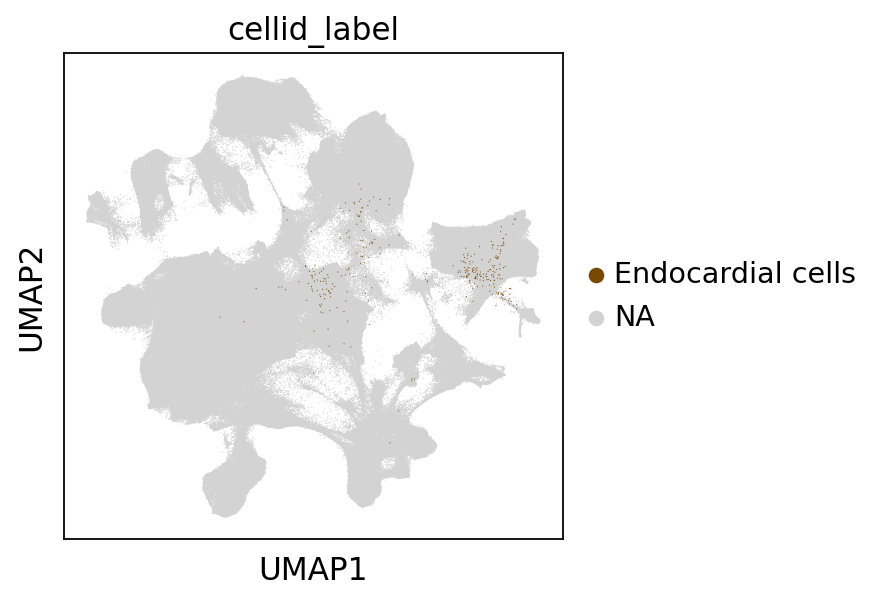

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


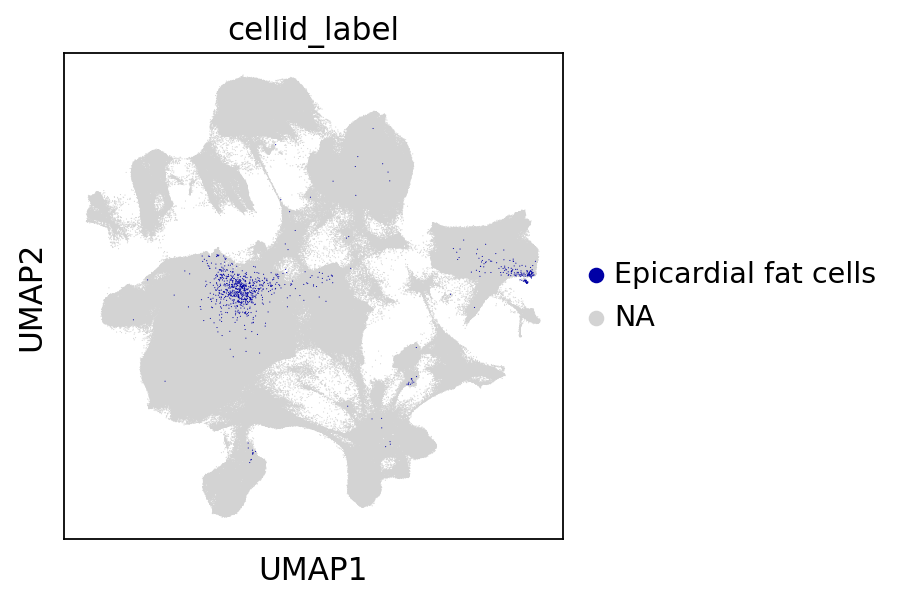

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


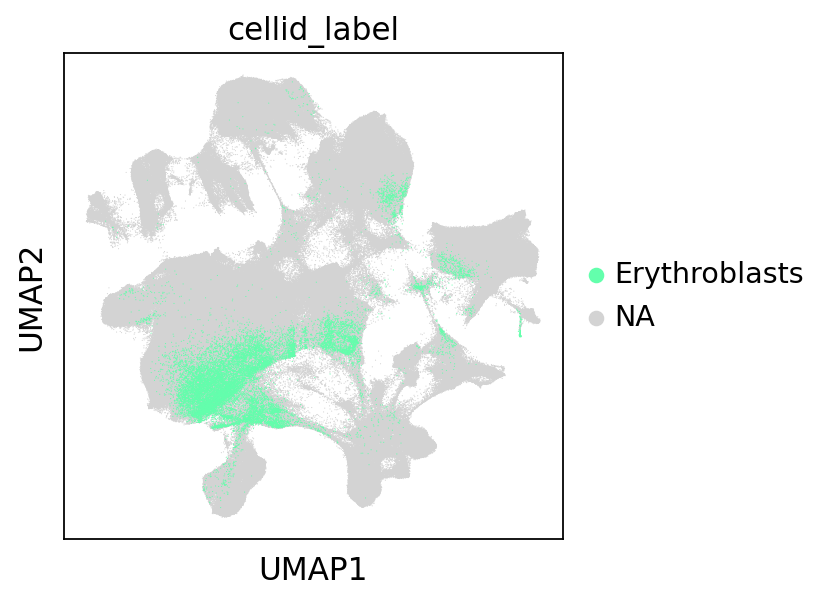

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


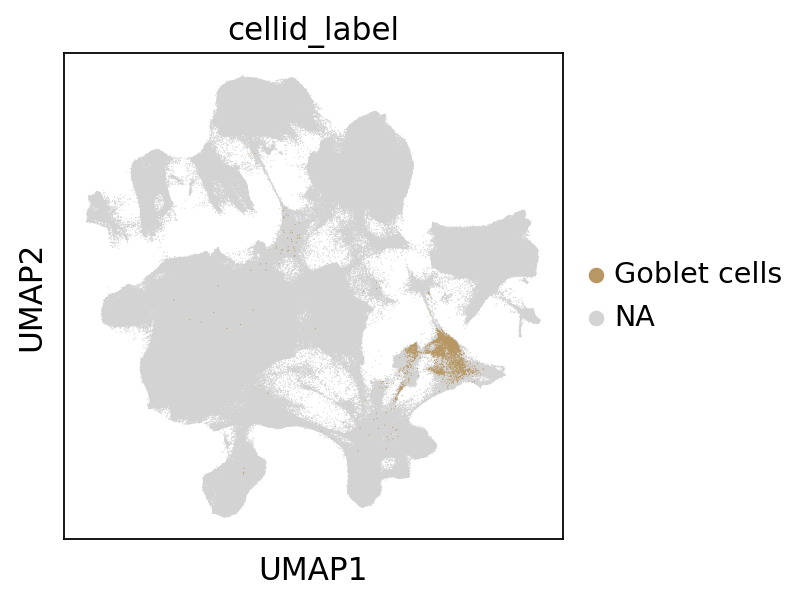

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


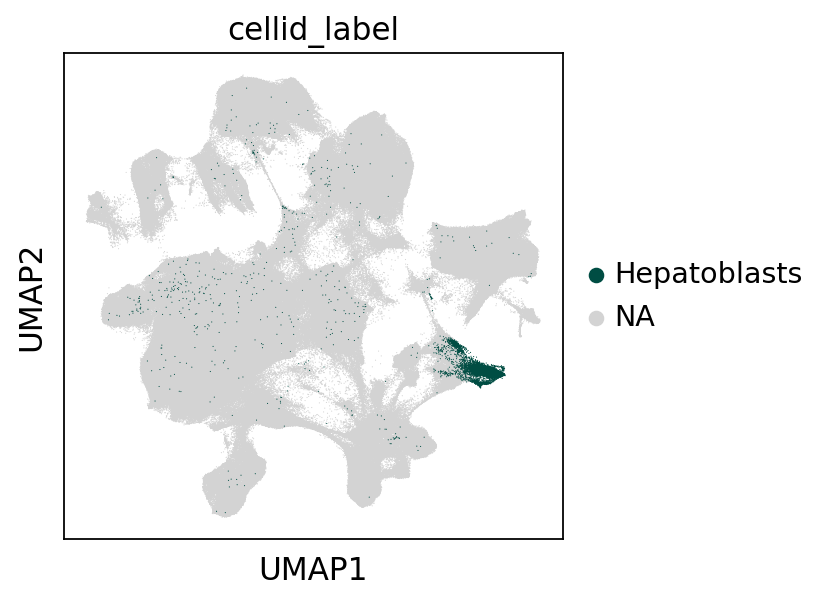

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


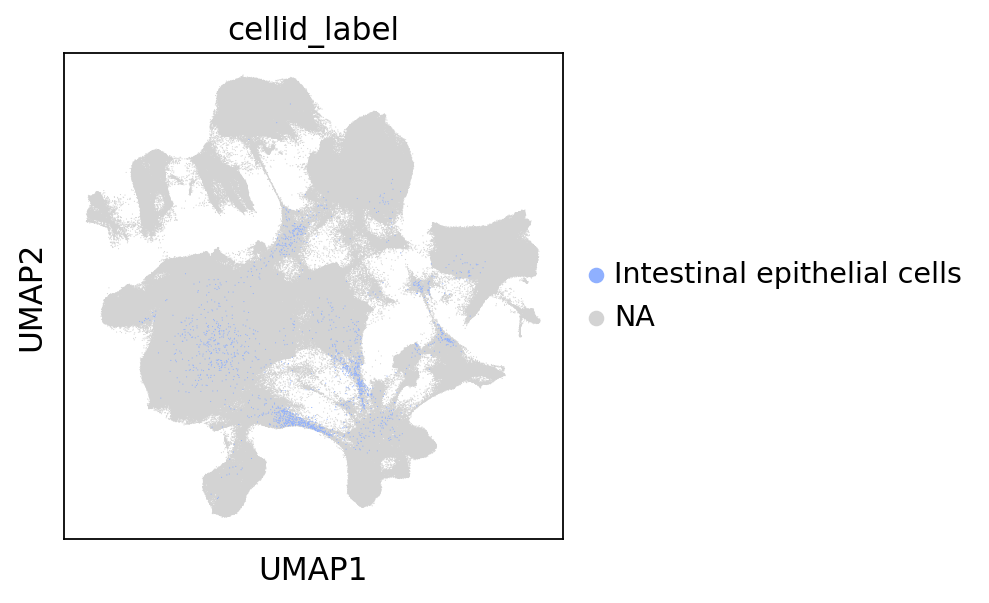

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


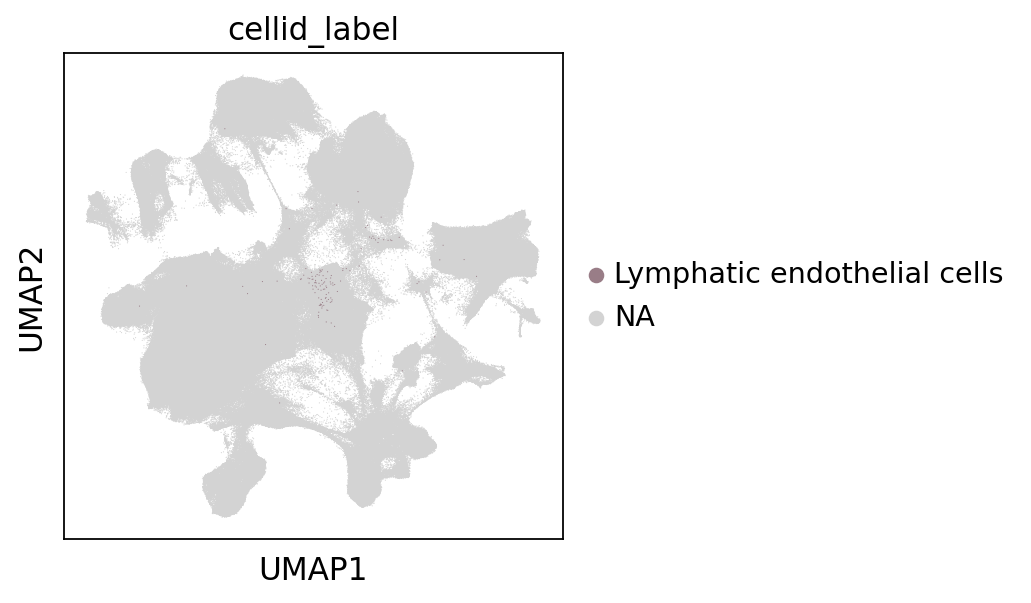

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


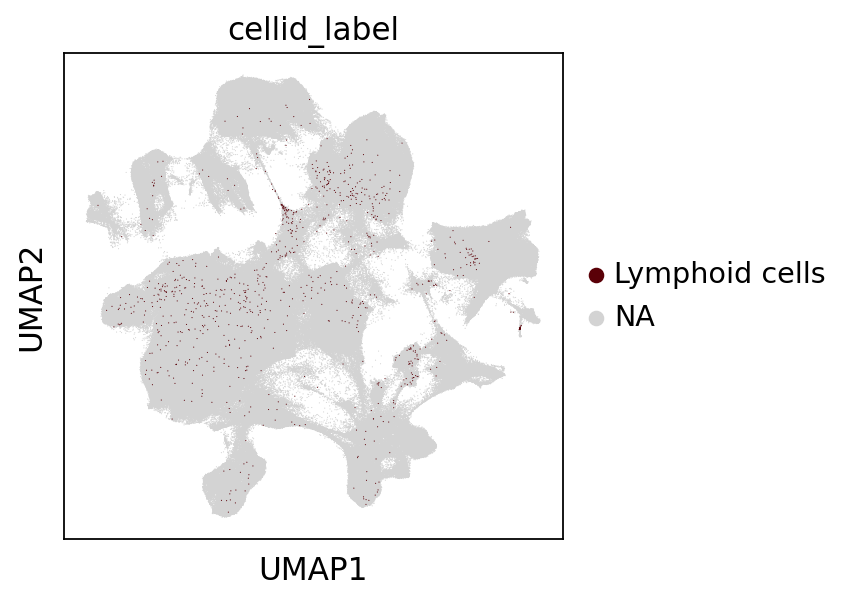

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


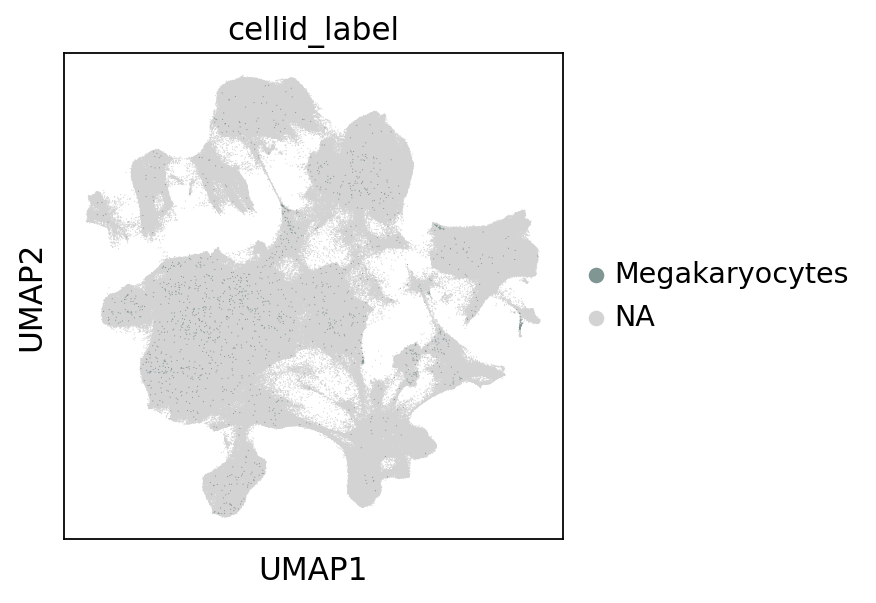

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


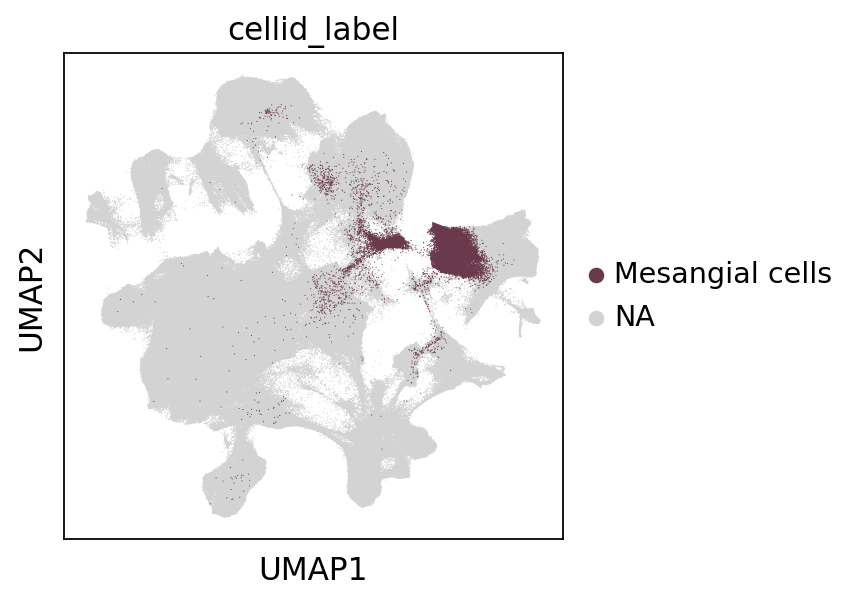

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


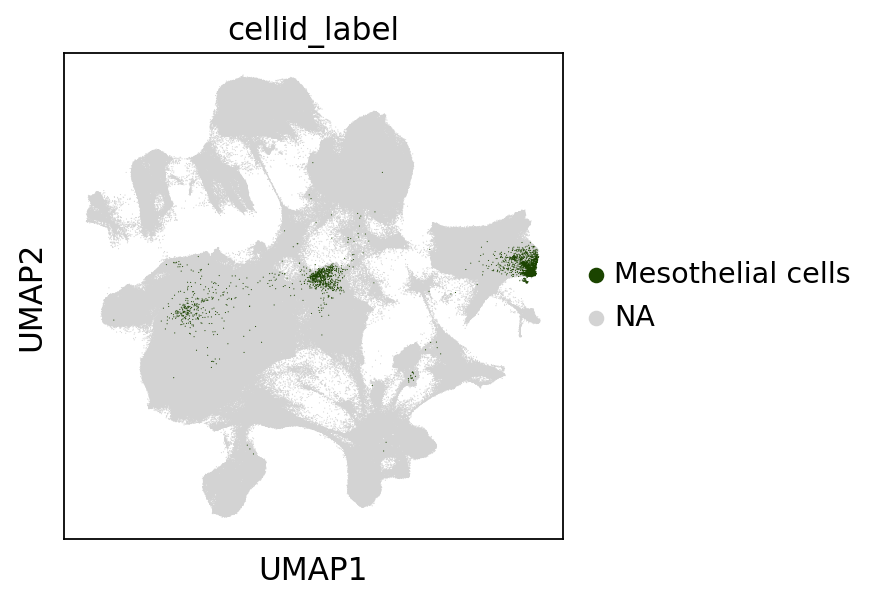

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


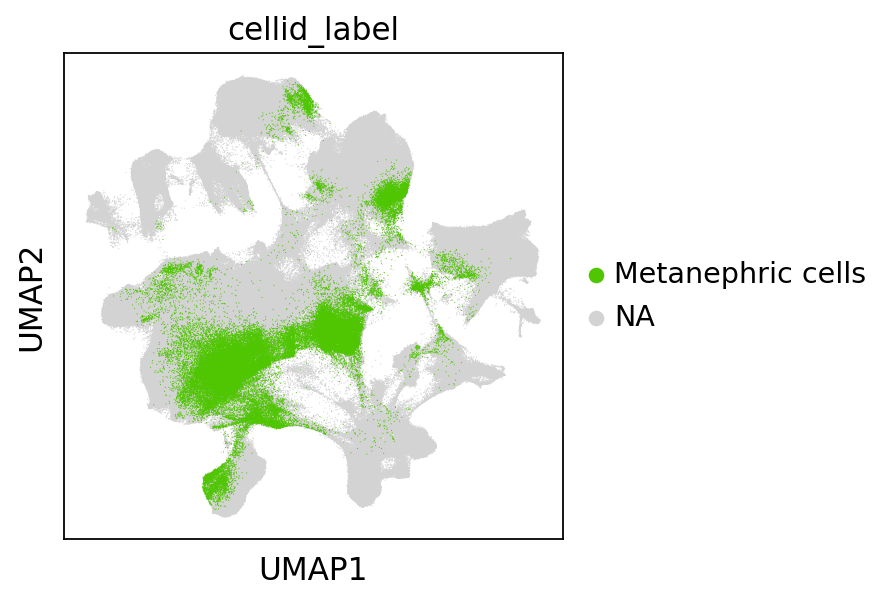

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


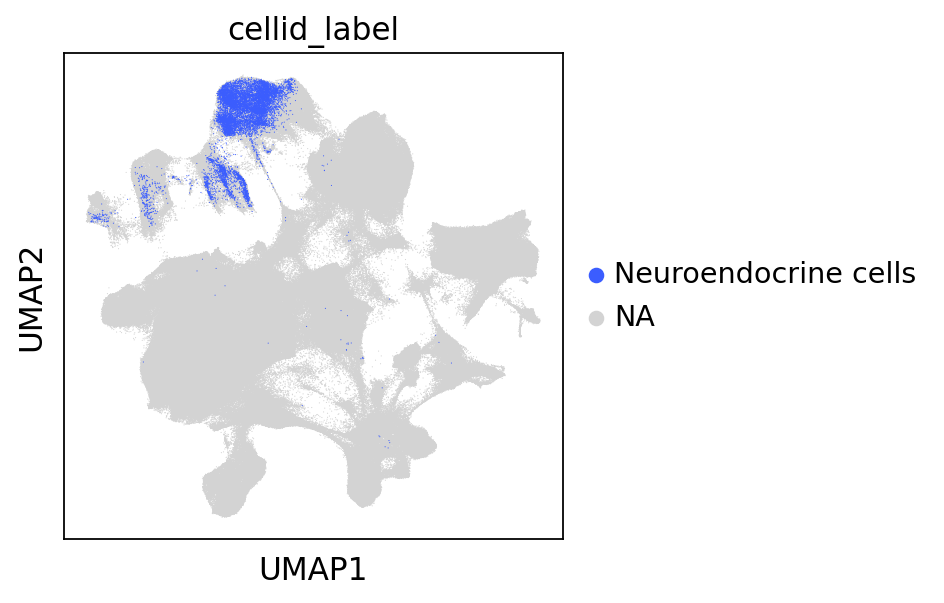

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


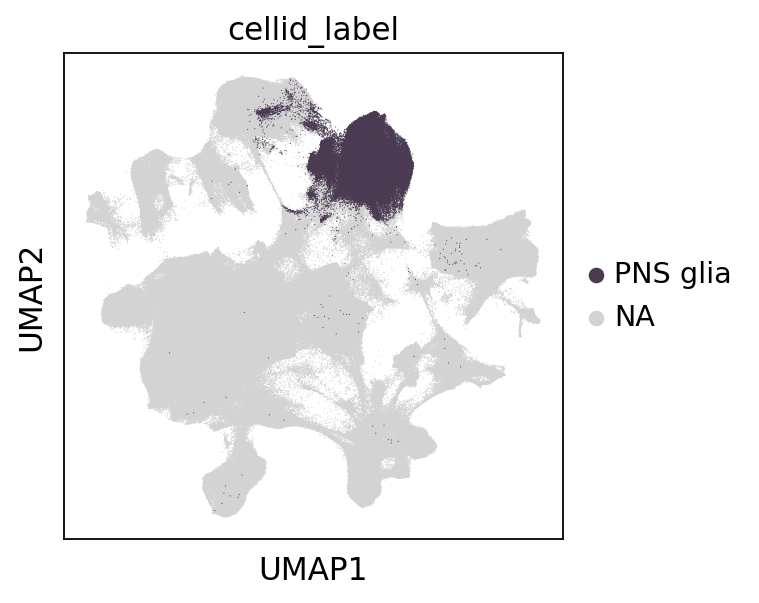

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


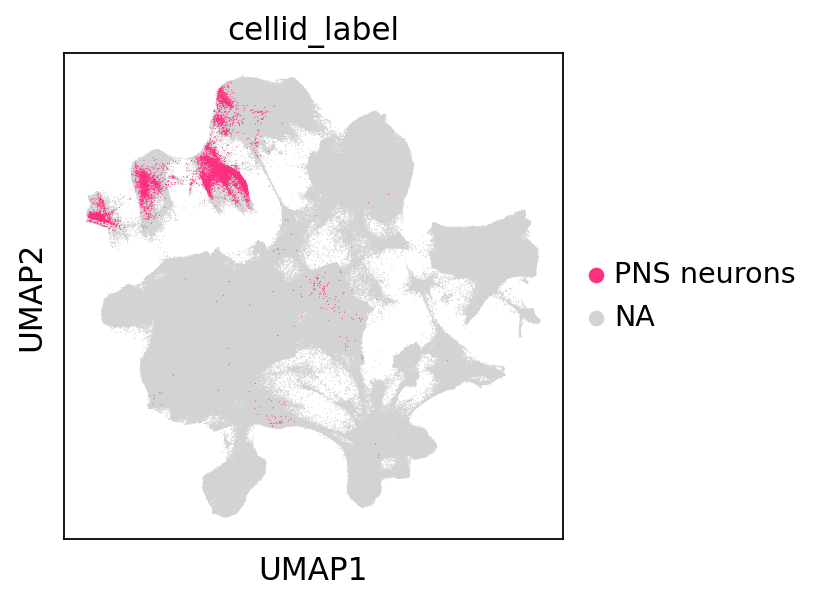

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


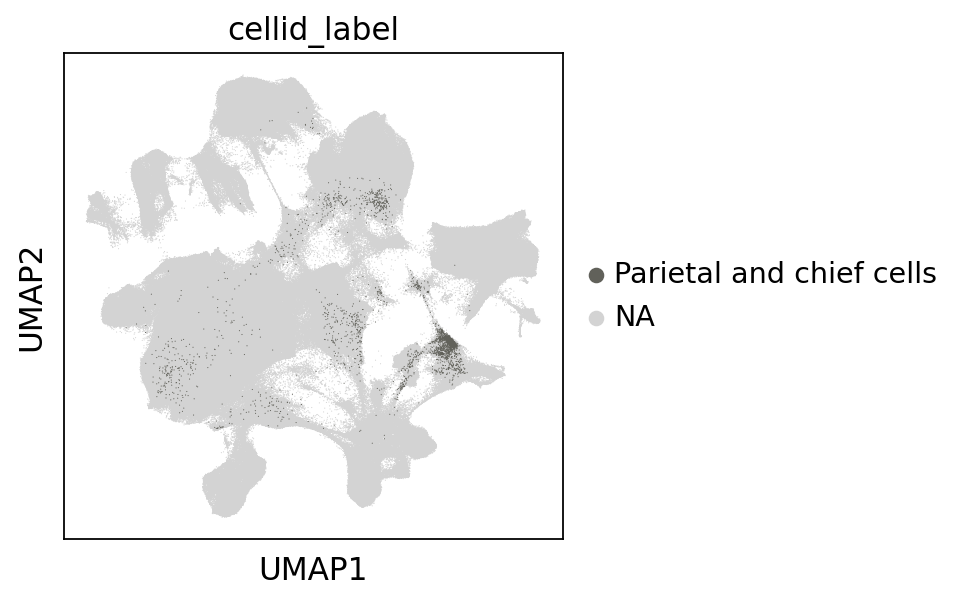

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


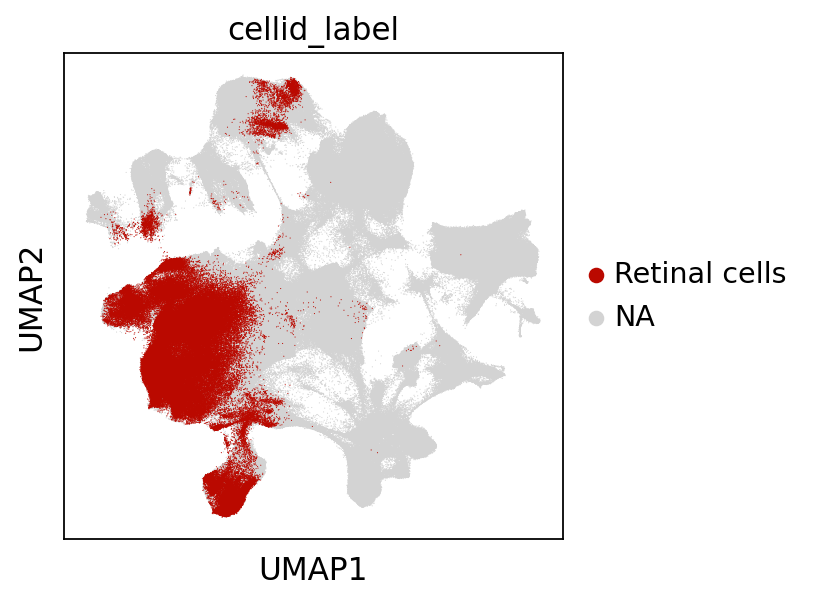

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


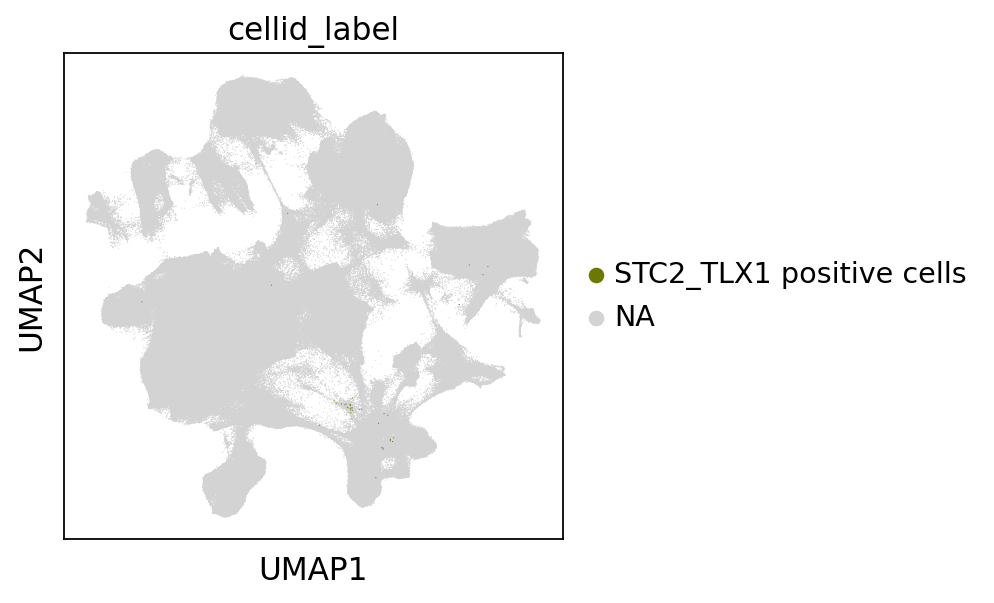

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


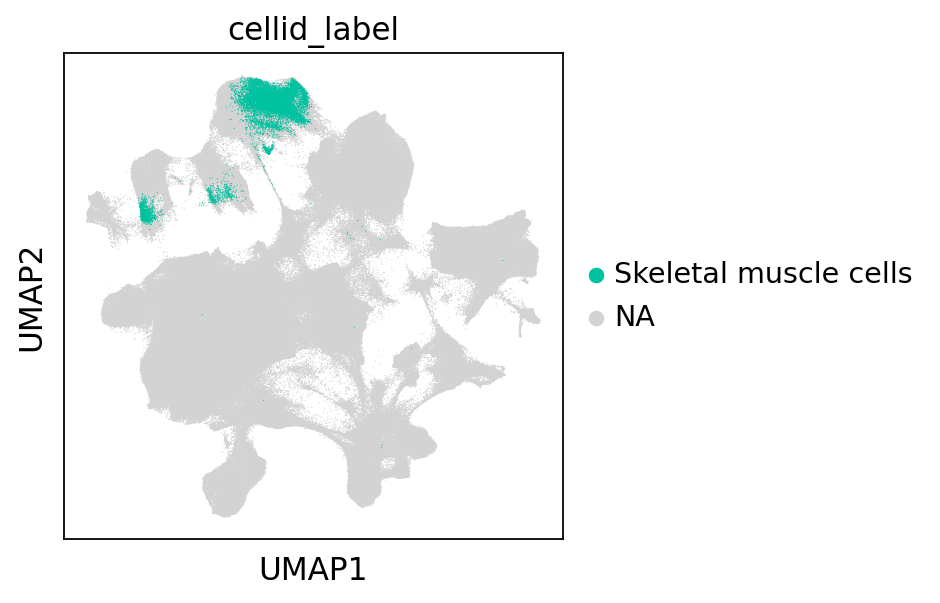

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


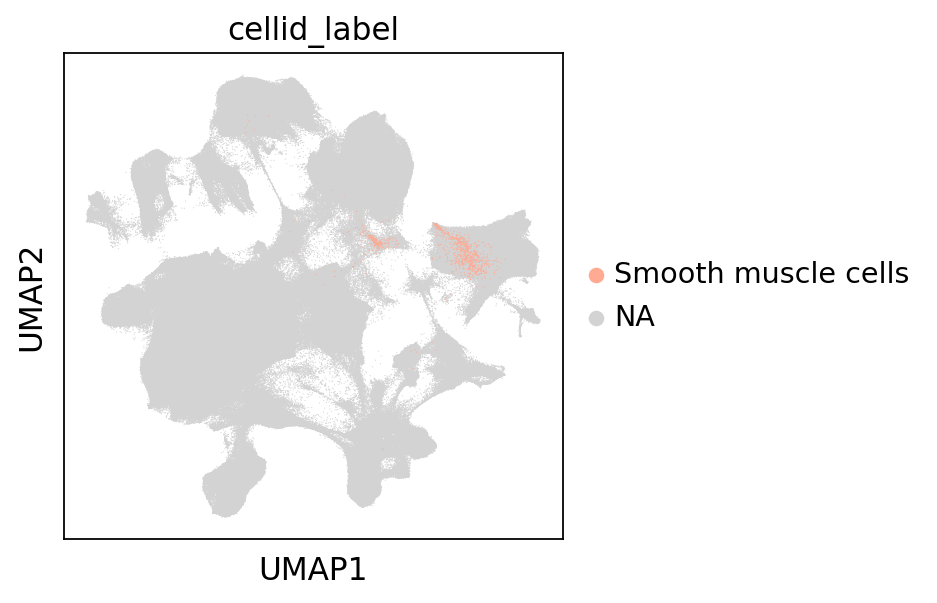

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


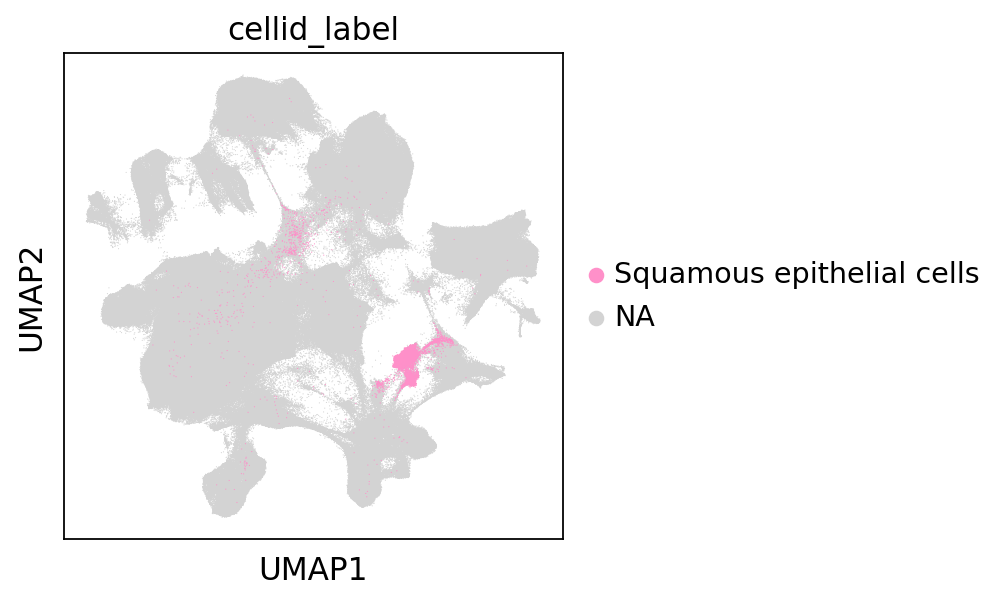

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


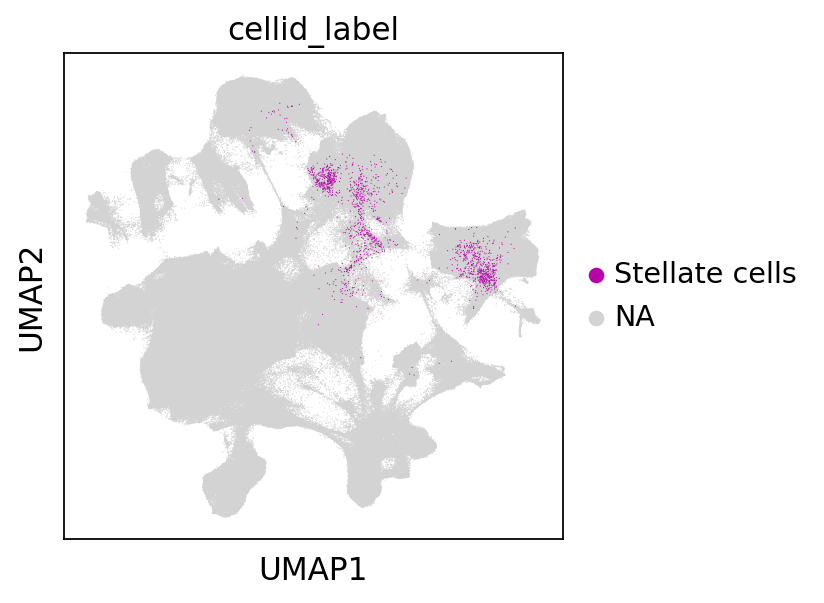

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


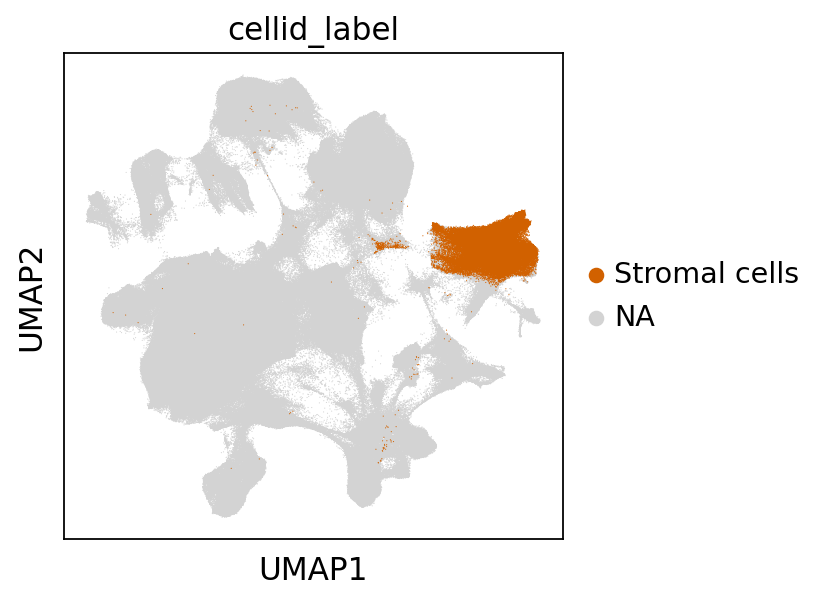

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


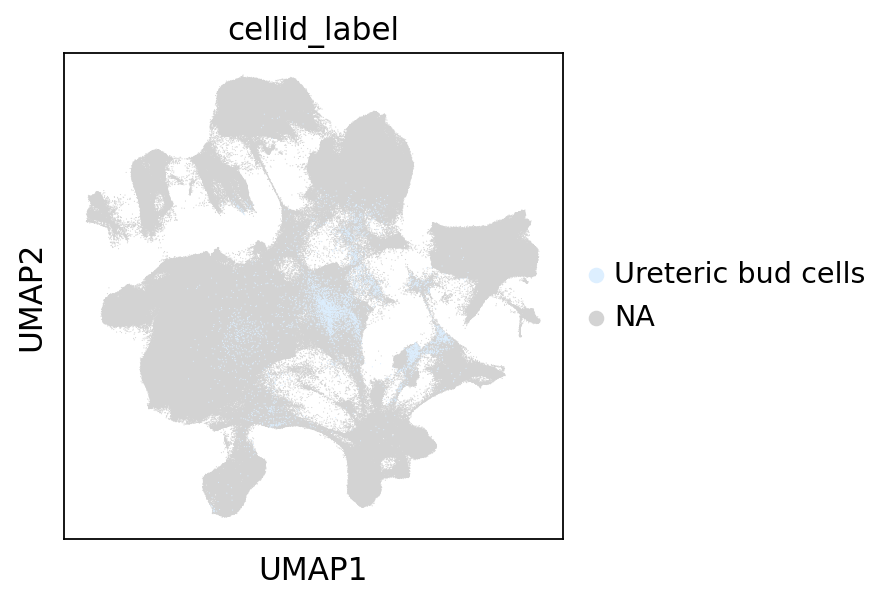

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


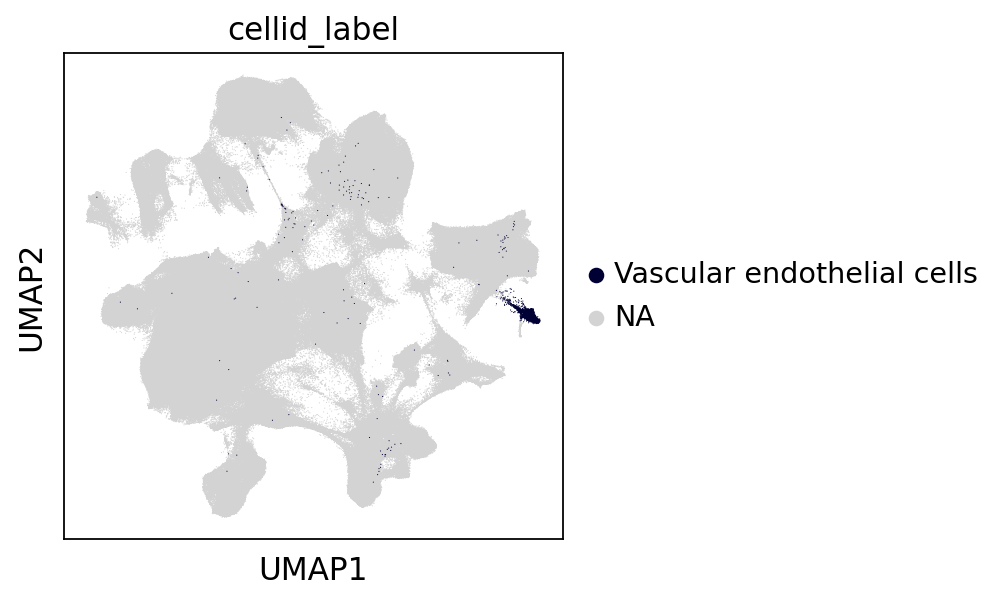

In [36]:
for ct in celltypes:
    sc.pl.umap(adata, color='cellid_label', groups=ct, size=1.0)

In [37]:
adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.cellid_annotated.h5ad")

## Digging Into Enrichments

In [ ]:
cellid_enrichments = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/fca/cellid_enrichments.tsv", sep="\t")

First, what does it look like for a really distinct assignment?

In [ ]:
vasc_cells = cellid_labels[cellid_labels['value'] == "Vascular endothelial cells"]['cell']

In [ ]:
pd.set_option('display.max_columns', 50)
cellid_enrichments[cellid_enrichments['cell'].isin(vasc_cells)]

Vascular endothelial cells do actually display some pretty strong enrichment for the other endothelial cell types like endocardial and lymphatic endothelial cells.

Now let's look at acinar cells, which were a bit more surprising

In [ ]:
acinar_cells = cellid_labels[cellid_labels['value'] == "Acinar cells"]['cell']

In [ ]:
cellid_enrichments[cellid_enrichments['cell'].isin(acinar_cells)]

Acinar cells, ductal cells, intestinal epithelial cells, ureteric bud cells, parietal and chief cells, metanephric cells, all of these are pretty enriched, with -log10p over 10. They also are all epithelial cell types.

Are erythroblasts getting similar labels?

In [ ]:
erythroblasts = cellid_labels[cellid_labels['value'] == "Erythroblasts"]['cell']

In [ ]:
cellid_enrichments[cellid_enrichments['cell'].isin(erythroblasts)]

## QC

In [2]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.cellid_annotated.h5ad")

In [3]:
adata.obs['cellid_label'] = [s.replace(" ", "-") for s in adata.obs['cellid_label'].astype(str)]

In [4]:
sc.pp.calculate_qc_metrics(adata, layer='counts', inplace=True)

Text(0.5, 1.0, 'N Genes By Counts')

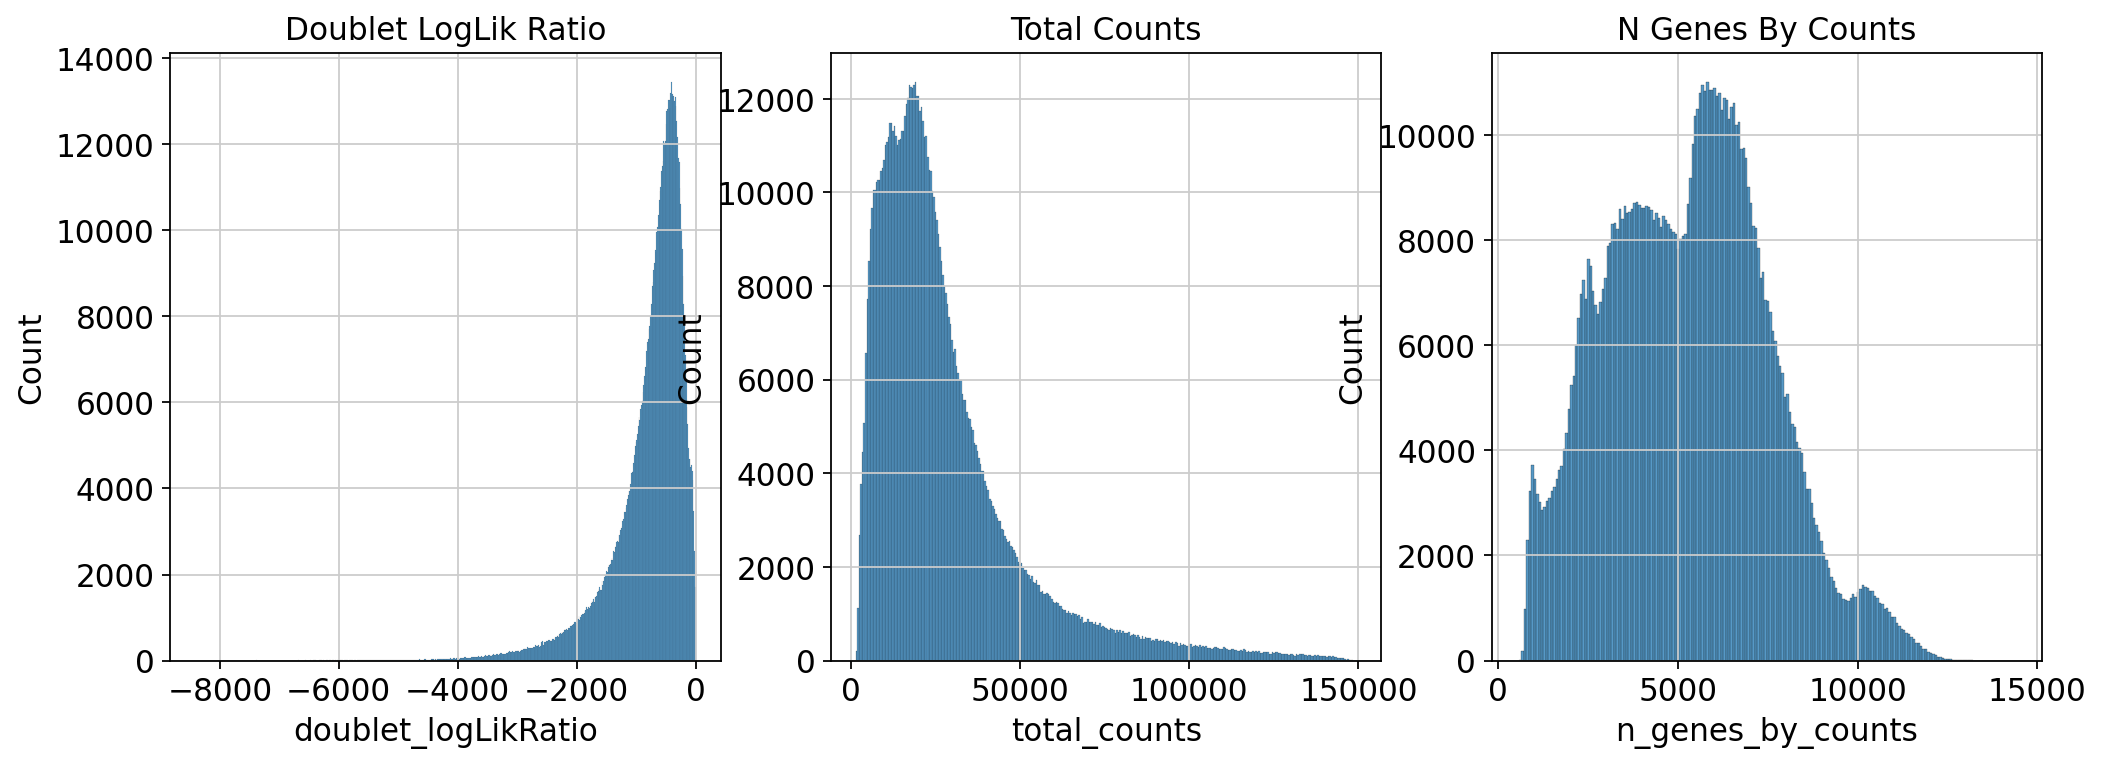

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

sns.histplot(ax=axes[0], x=adata.obs['doublet_logLikRatio'])
axes[0].set_title('Doublet LogLik Ratio')

sns.histplot(ax=axes[1], x=adata.obs['total_counts'])
axes[1].set_title('Total Counts')

sns.histplot(ax=axes[2], x=adata.obs['n_genes_by_counts'])
axes[2].set_title('N Genes By Counts')

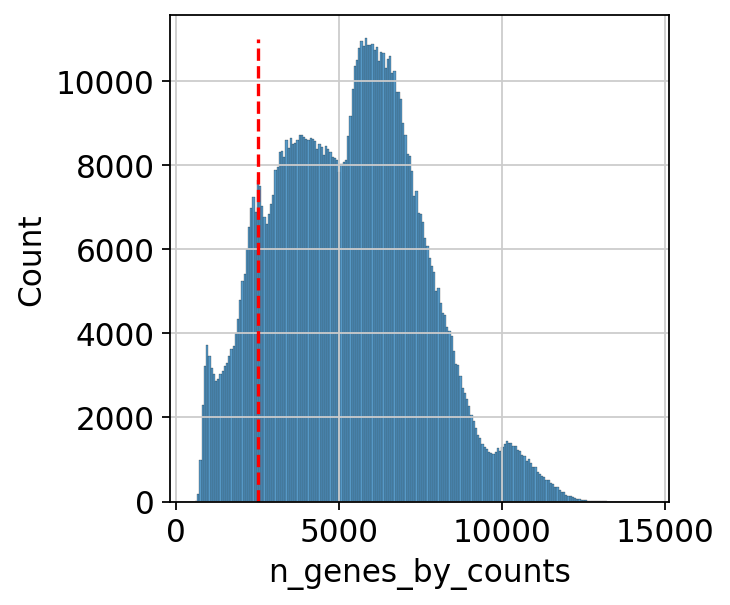

In [6]:
ngenes_cutoff = 2500
sns.histplot(x=adata.obs['n_genes_by_counts'])
plt.plot([ngenes_cutoff, ngenes_cutoff], [0, 11000], 'r--')

In [7]:
adata_filt = adata[adata.obs['n_genes_by_counts'] >= ngenes_cutoff]

In [8]:
adata_filt.obs[['cellid_label']].value_counts() / adata.obs[['cellid_label']].value_counts()

cellid_label                             
Acinar-cells                                 0.947538
Adrenocortical-cells                         0.677043
Bronchiolar-and-alveolar-epithelial-cells    0.998039
CNS-glia                                     0.704159
CNS-neurons                                  0.667433
Cardiomyocytes                               0.944746
Ciliated-epithelial-cells                    0.956187
Ductal-cells                                 0.734961
Endocardial-cells                            0.870662
Epicardial-fat-cells                         0.810127
Erythroblasts                                0.993413
Goblet-cells                                 0.932478
Hepatoblasts                                 0.938759
Intestinal-epithelial-cells                  0.983255
Lymphatic-endothelial-cells                  0.888889
Lymphoid-cells                               0.973333
Megakaryocytes                               0.968053
Mesangial-cells                         

CNS glia, CNS neurons were hit the hardest, but it looks like it should be ok

In [9]:
adata = adata_filt

In [7]:
adata = adata[adata.obs['n_genes_by_counts'] >= ngenes_cutoff]

In [ ]:
adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.cellid_annotated.filtered.h5ad")

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


# Aggregation

In [4]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/eb_pflog1ppfnorm.cellid_annotated.filtered.h5ad")

In [5]:
adata = adata[~adata.obs['cellid_label'].isnull()]

In [6]:
spacey_types = adata.obs['cellid_label'].cat.categories
spacey_types

Index(['Acinar cells', 'Adrenocortical cells',
       'Bronchiolar and alveolar epithelial cells', 'CNS glia', 'CNS neurons',
       'Cardiomyocytes', 'Ciliated epithelial cells', 'Ductal cells',
       'Endocardial cells', 'Epicardial fat cells', 'Erythroblasts',
       'Goblet cells', 'Hepatoblasts', 'Intestinal epithelial cells',
       'Lymphatic endothelial cells', 'Lymphoid cells', 'Megakaryocytes',
       'Mesangial cells', 'Mesothelial cells', 'Metanephric cells',
       'Neuroendocrine cells', 'PNS glia', 'PNS neurons',
       'Parietal and chief cells', 'Retinal cells', 'STC2_TLX1 positive cells',
       'Skeletal muscle cells', 'Smooth muscle cells',
       'Squamous epithelial cells', 'Stellate cells', 'Stromal cells',
       'Ureteric bud cells', 'Vascular endothelial cells'],
      dtype='object')

In [7]:
reformatted_types = [s.replace(" ", "-") for s in list(spacey_types)]
reformatted_types

['Acinar-cells',
 'Adrenocortical-cells',
 'Bronchiolar-and-alveolar-epithelial-cells',
 'CNS-glia',
 'CNS-neurons',
 'Cardiomyocytes',
 'Ciliated-epithelial-cells',
 'Ductal-cells',
 'Endocardial-cells',
 'Epicardial-fat-cells',
 'Erythroblasts',
 'Goblet-cells',
 'Hepatoblasts',
 'Intestinal-epithelial-cells',
 'Lymphatic-endothelial-cells',
 'Lymphoid-cells',
 'Megakaryocytes',
 'Mesangial-cells',
 'Mesothelial-cells',
 'Metanephric-cells',
 'Neuroendocrine-cells',
 'PNS-glia',
 'PNS-neurons',
 'Parietal-and-chief-cells',
 'Retinal-cells',
 'STC2_TLX1-positive-cells',
 'Skeletal-muscle-cells',
 'Smooth-muscle-cells',
 'Squamous-epithelial-cells',
 'Stellate-cells',
 'Stromal-cells',
 'Ureteric-bud-cells',
 'Vascular-endothelial-cells']

In [10]:
adata.obs.loc[:, 'cellid_label'].replace(to_replace=spacey_types, value=reformatted_types, inplace=True)

## Filter Samples

In [11]:
cell_counts = adata.obs[['donor_id', 'cellid_label']]
cell_counts = pd.DataFrame(cell_counts.groupby('cellid_label').value_counts()).reset_index(inplace=False).rename(columns={0: "n_cells_unfiltered", 'cellid_label': 'type'})
cell_counts

type donor_id  n_cells_unfiltered
0                   Acinar-cells  NA18511                2277
1                   Acinar-cells  NA18858                1932
2                   Acinar-cells  NA19160                1928
3                   Acinar-cells  NA18856                1887
4                   Acinar-cells  NA18505                1788
...                          ...      ...                 ...
1744  Vascular-endothelial-cells  NA19193                   1
1745  Vascular-endothelial-cells  NA18520                   1
1746  Vascular-endothelial-cells  NA19209                   0
1747  Vascular-endothelial-cells  NA19101                   0
1748  Vascular-endothelial-cells  NA19114                   0

[1749 rows x 3 columns]

In [12]:
cell_counts['individual'] = [s.replace("NA", "") for s in cell_counts['donor_id']]
cell_counts['ind_type'] = cell_counts['individual'].astype(str) + "_" + cell_counts['type'].astype(str)
cell_counts = cell_counts[['ind_type', 'individual', 'type', 'n_cells_unfiltered']]
cell_counts

ind_type individual                        type  \
0                   18511_Acinar-cells      18511                Acinar-cells   
1                   18858_Acinar-cells      18858                Acinar-cells   
2                   19160_Acinar-cells      19160                Acinar-cells   
3                   18856_Acinar-cells      18856                Acinar-cells   
4                   18505_Acinar-cells      18505                Acinar-cells   
...                                ...        ...                         ...   
1744  19193_Vascular-endothelial-cells      19193  Vascular-endothelial-cells   
1745  18520_Vascular-endothelial-cells      18520  Vascular-endothelial-cells   
1746  19209_Vascular-endothelial-cells      19209  Vascular-endothelial-cells   
1747  19101_Vascular-endothelial-cells      19101  Vascular-endothelial-cells   
1748  19114_Vascular-endothelial-cells      19114  Vascular-endothelial-cells   

      n_cells_unfiltered  
0                   2277  
1                   1932  
2                   1928  
3                   1887  
4                   1788  
...                  ...  
1744                   1  
1745                   1  
1746                   0  
1747                   0  
1748                   0  

[1749 rows x 4 columns]

In [13]:
cell_counts['dropped'] = cell_counts['n_cells_unfiltered'] < 5

## Filter cell types

In [14]:
ind_counts = cell_counts[cell_counts['n_cells_unfiltered'] >= 5]
ind_counts = pd.DataFrame(ind_counts[['type']].value_counts()).reset_index(inplace=False).rename(columns={0: "n_unfiltered"})
ind_counts = ind_counts[ind_counts['n_unfiltered']>25]
ind_counts

type  n_unfiltered
0                                Acinar-cells            53
1                                    CNS-glia            53
2                                 CNS-neurons            53
3                   Ciliated-epithelial-cells            53
4                               Erythroblasts            53
5                           Metanephric-cells            53
6                               Retinal-cells            52
7                                Ductal-cells            52
8                                    PNS-glia            52
9                        Neuroendocrine-cells            52
10                            Mesangial-cells            51
11                  Squamous-epithelial-cells            51
12                                PNS-neurons            51
13                             Megakaryocytes            51
14                              Stromal-cells            50
15                               Hepatoblasts            50
16                      Skeletal-muscle-cells            50
17                         Ureteric-bud-cells            49
18                   Parietal-and-chief-cells            47
19                             Lymphoid-cells            47
20                          Mesothelial-cells            47
21                               Goblet-cells            47
22                 Vascular-endothelial-cells            46
23                Intestinal-epithelial-cells            45
24                             Cardiomyocytes            43
25                       Epicardial-fat-cells            42
26                             Stellate-cells            42
27  Bronchiolar-and-alveolar-epithelial-cells            41
28                        Smooth-muscle-cells            33

In [15]:
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/eb_cellid_2/pseudobulk_scran/samples_per_celltype.tsv",
                  sep="\t", index=False)
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/eb_cellid_2/pseudobulk_tmm/samples_per_celltype.tsv",
                  sep="\t", index=False)

## Filter cells

In [16]:
cell_types_inc = ind_counts['type']
samples_inc = cell_counts[(cell_counts['dropped'] == False) & (cell_counts['type'].isin(cell_types_inc))]['ind_type']

In [40]:
cell_subset = adata.obs[['donor_id']].copy()
cell_subset['type'] = adata.obs['cellid_label']
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id'].astype(str)]
cell_subset['sample'] = cell_subset['ind'].astype(str) + "_" + cell_subset['type'].astype(str)
cell_subset = cell_subset[cell_subset['sample'].isin(samples_inc)]
cell_subset

donor_id               type    ind  \
cell                                                      
AAACCCACAGAAGTGC-1    NA18870      Retinal-cells  18870   
AAACGAAAGGTATTGA-1    NA18870        CNS-neurons  18870   
AAACGCTAGCAGGTCA-1    NA18870           PNS-glia  18870   
AAACGCTAGTCACTCA-1    NA18913  Metanephric-cells  18913   
AAACGCTGTAGCCAGA-1    NA18870        CNS-neurons  18870   
...                       ...                ...    ...   
TTTGATCAGGTGATCG-118  NA18511       Acinar-cells  18511   
TTTGATCGTCGCGTTG-118  NA19160      Erythroblasts  19160   
TTTGATCTCACGTCCT-118  NA18511      Erythroblasts  18511   
TTTGTTGAGGATATAC-118  NA18511       Acinar-cells  18511   
TTTGTTGGTTTGGAGG-118  NA18511       Acinar-cells  18511   

                                       sample  
cell                                           
AAACCCACAGAAGTGC-1        18870_Retinal-cells  
AAACGAAAGGTATTGA-1          18870_CNS-neurons  
AAACGCTAGCAGGTCA-1             18870_PNS-glia  
AAACGCTAGTCACTCA-1    18913_Metanephric-cells  
AAACGCTGTAGCCAGA-1          18870_CNS-neurons  
...                                       ...  
TTTGATCAGGTGATCG-118       18511_Acinar-cells  
TTTGATCGTCGCGTTG-118      19160_Erythroblasts  
TTTGATCTCACGTCCT-118      18511_Erythroblasts  
TTTGTTGAGGATATAC-118       18511_Acinar-cells  
TTTGTTGGTTTGGAGG-118       18511_Acinar-cells  

[537276 rows x 4 columns]

In [41]:
adata = adata[cell_subset.index]

Still need to figure out why this needs to be rerun

In [43]:
adata.obs.loc[:, 'cellid_label'].replace(to_replace=spacey_types, value=reformatted_types, inplace=True)

Not going to do the in-depth cell filtering here, so just jumping ahead

In [45]:
filtered_counts = adata.obs[['donor_id', 'cellid_label', 'total_counts']].copy()
filtered_counts['n_cells_filtered'] = 1
filtered_counts['individual'] = [s.replace("NA", "") for s in filtered_counts['donor_id']]
filtered_counts['ind_type'] = filtered_counts['individual'].astype(str) + "_" + filtered_counts['cellid_label'].astype(str)
filtered_counts = filtered_counts.drop(columns=['donor_id', 'individual', 'cellid_label'])
filtered_counts = filtered_counts.groupby('ind_type').agg({'total_counts': 'sum', 'n_cells_filtered': 'count'})
filtered_counts = filtered_counts.reset_index().astype({'total_counts': 'int'})
filtered_counts

ind_type  total_counts  n_cells_filtered
0                   18486_Acinar-cells      18257891               759
1                       18486_CNS-glia       8493616               400
2                    18486_CNS-neurons       8388843               455
3                 18486_Cardiomyocytes       3079749                82
4      18486_Ciliated-epithelial-cells       3688490               181
...                                ...           ...               ...
1404   19257_Squamous-epithelial-cells       3513640                86
1405              19257_Stellate-cells        375348                14
1406               19257_Stromal-cells      17843852               580
1407          19257_Ureteric-bud-cells        303244                10
1408  19257_Vascular-endothelial-cells       3093173                72

[1409 rows x 3 columns]

In [46]:
cell_counts_filtered = cell_counts.merge(filtered_counts, on='ind_type', how='left').fillna({'total_counts': 0, 'n_cells_filtered': 0}).astype({'total_counts': 'int', 'n_cells_filtered': 'int'})
cell_counts_filtered['dropped'] = cell_counts_filtered['n_cells_filtered'] < 5
cell_counts_filtered = cell_counts_filtered.sort_values(by="n_cells_filtered", ascending=False)

In [47]:
cell_counts_filtered.to_csv("/project2/gilad/jpopp/ebQTL/data/static/eb_cellid_2/pseudobulk_scran/sample_summary.tsv", sep="\t")
cell_counts_filtered.to_csv("/project2/gilad/jpopp/ebQTL/data/static/eb_cellid_2/pseudobulk_tmm/sample_summary.tsv", sep="\t")

In [48]:
ind_counts = cell_counts_filtered[cell_counts_filtered['n_cells_filtered'] >= 5]
ind_counts = pd.DataFrame(ind_counts[['type']].value_counts()).reset_index(inplace=False).rename(columns={0: "n_filtered"})
ind_counts = ind_counts[ind_counts['n_filtered']>25]
ind_counts

type  n_filtered
0                                Acinar-cells          53
1                                    CNS-glia          53
2                                 CNS-neurons          53
3                   Ciliated-epithelial-cells          53
4                               Erythroblasts          53
5                           Metanephric-cells          53
6                               Retinal-cells          52
7                                Ductal-cells          52
8                                    PNS-glia          52
9                        Neuroendocrine-cells          52
10                            Mesangial-cells          51
11                  Squamous-epithelial-cells          51
12                                PNS-neurons          51
13                             Megakaryocytes          51
14                              Stromal-cells          50
15                               Hepatoblasts          50
16                      Skeletal-muscle-cells          50
17                         Ureteric-bud-cells          49
18                   Parietal-and-chief-cells          47
19                             Lymphoid-cells          47
20                          Mesothelial-cells          47
21                               Goblet-cells          47
22                 Vascular-endothelial-cells          46
23                Intestinal-epithelial-cells          45
24                             Cardiomyocytes          43
25                       Epicardial-fat-cells          42
26                             Stellate-cells          42
27  Bronchiolar-and-alveolar-epithelial-cells          41
28                        Smooth-muscle-cells          33

In [49]:
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/eb_cellid_2/pseudobulk_scran/samples_per_celltype.tsv",
                  sep="\t", index=False)
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/eb_cellid_2/pseudobulk_tmm/samples_per_celltype.tsv",
                  sep="\t", index=False)

## Aggregate

In [52]:
cell_subset = adata.obs[['donor_id']].copy()
cell_subset['type'] = adata.obs[['cellid_label']]
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id'].astype(str)]
cell_subset['sample'] = cell_subset['ind'] + "_" + cell_subset['type']
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['sample']])
onehot

<537276x1409 sparse matrix of type '<class 'numpy.float64'>'
	with 537276 stored elements in Compressed Sparse Row format>

In [53]:
cell_subset

donor_id               type    ind  \
cell                                                      
AAACCCACAGAAGTGC-1    NA18870      Retinal-cells  18870   
AAACGAAAGGTATTGA-1    NA18870        CNS-neurons  18870   
AAACGCTAGCAGGTCA-1    NA18870           PNS-glia  18870   
AAACGCTAGTCACTCA-1    NA18913  Metanephric-cells  18913   
AAACGCTGTAGCCAGA-1    NA18870        CNS-neurons  18870   
...                       ...                ...    ...   
TTTGATCAGGTGATCG-118  NA18511       Acinar-cells  18511   
TTTGATCGTCGCGTTG-118  NA19160      Erythroblasts  19160   
TTTGATCTCACGTCCT-118  NA18511      Erythroblasts  18511   
TTTGTTGAGGATATAC-118  NA18511       Acinar-cells  18511   
TTTGTTGGTTTGGAGG-118  NA18511       Acinar-cells  18511   

                                       sample  
cell                                           
AAACCCACAGAAGTGC-1        18870_Retinal-cells  
AAACGAAAGGTATTGA-1          18870_CNS-neurons  
AAACGCTAGCAGGTCA-1             18870_PNS-glia  
AAACGCTAGTCACTCA-1    18913_Metanephric-cells  
AAACGCTGTAGCCAGA-1          18870_CNS-neurons  
...                                       ...  
TTTGATCAGGTGATCG-118       18511_Acinar-cells  
TTTGATCGTCGCGTTG-118      19160_Erythroblasts  
TTTGATCTCACGTCCT-118      18511_Erythroblasts  
TTTGTTGAGGATATAC-118       18511_Acinar-cells  
TTTGTTGGTTTGGAGG-118       18511_Acinar-cells  

[537276 rows x 4 columns]

In [54]:
pseudobulk_sum = adata.layers['counts'].transpose() * onehot

In [55]:
pseudobulk_sum = pd.DataFrame.sparse.from_spmatrix(pseudobulk_sum, index=adata.var_names, columns=cell_subset['sample'].astype("category").cat.categories)

In [56]:
pseudobulk_sum.to_csv("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/eb_cellid_2.pseudobulk_tmm.tsv",
                       sep="\t", index_label="gene")

In [57]:
pseudobulk_sum

18486_Acinar-cells  18486_CNS-glia  18486_CNS-neurons  \
MIR1302-2HG                 0.0             0.0                0.0   
OR4F5                       0.0             0.0                0.0   
AL627309.1                  3.0             1.0                3.0   
AL627309.3                  0.0             0.0                0.0   
AL627309.2                  0.0             0.0                0.0   
...                         ...             ...                ...   
AC136616.3                  0.0             0.0                0.0   
AC023491.2                  0.0             0.0                0.0   
AC007325.1                  0.0             0.0                0.0   
AC007325.4                 24.0             1.0                6.0   
AC007325.2                  9.0             0.0                0.0   

             18486_Cardiomyocytes  18486_Ciliated-epithelial-cells  \
MIR1302-2HG                   0.0                              0.0   
OR4F5                         0.0                              0.0   
AL627309.1                    1.0                              3.0   
AL627309.3                    0.0                              0.0   
AL627309.2                    0.0                              0.0   
...                           ...                              ...   
AC136616.3                    0.0                              0.0   
AC023491.2                    1.0                              0.0   
AC007325.1                    0.0                              0.0   
AC007325.4                    4.0                             37.0   
AC007325.2                    0.0                              1.0   

             18486_Ductal-cells  18486_Epicardial-fat-cells  \
MIR1302-2HG                 0.0                         0.0   
OR4F5                       0.0                         0.0   
AL627309.1                  0.0                         0.0   
AL627309.3                  0.0                         0.0   
AL627309.2                  0.0                         0.0   
...                         ...                         ...   
AC136616.3                  0.0                         0.0   
AC023491.2                  0.0                         0.0   
AC007325.1                  0.0                         0.0   
AC007325.4                  4.0                         1.0   
AC007325.2                  5.0                         0.0   

             18486_Erythroblasts  18486_Goblet-cells  18486_Hepatoblasts  ...  \
MIR1302-2HG                  0.0                 0.0                 1.0  ...   
OR4F5                        0.0                 0.0                 0.0  ...   
AL627309.1                   3.0                 2.0                10.0  ...   
AL627309.3                   0.0                 0.0                 0.0  ...   
AL627309.2                   0.0                 0.0                 0.0  ...   
...                          ...                 ...                 ...  ...   
AC136616.3                   0.0                 0.0                 0.0  ...   
AC023491.2                   0.0                 0.0                 0.0  ...   
AC007325.1                   0.0                 0.0                 0.0  ...   
AC007325.4                   8.0                 4.0                21.0  ...   
AC007325.2                   0.0                 4.0                14.0  ...   

             19257_PNS-glia  19257_PNS-neurons  \
MIR1302-2HG             0.0                0.0   
OR4F5                   0.0                0.0   
AL627309.1              9.0                0.0   
AL627309.3              0.0                0.0   
AL627309.2              0.0                0.0   
...                     ...                ...   
AC136616.3              0.0                0.0   
AC023491.2              0.0                0.0   
AC007325.1              0.0                0.0   
AC007325.4             64.0               10.0   
AC007325.2              0.0                0.0   

